My plan is to first "understand the data distribution" before "selecting the matching algorithm"

Part A: Trajectory & "Loop" Discovery

Use the ground truth files to find where the Segway revisited the same spot across different days.


Action: 
Plot Day 1 vs. Day 2.


Goal: 
Identify $(x, y)$ coordinates where the robot is within ~5 meters of a previous path. 
These are your "Positive" matches for evaluation later.

In [2]:
import os
print("Current Working Directory:", os.getcwd())
print("Files in this folder:", os.listdir())

Current Working Directory: /home/ragini/Desktop/AMR_Lab3/notebooks
Files in this folder: ['descriptor_testing.ipynb', 'data_exploration.ipynb']


/tmp/ipykernel_17614/3088382611.py:11: DtypeWarning: Columns (0: x, 1: y, 2: z, 3: roll, 4: pitch, 5: yaw) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gt_file, header=None, names=column_names)


Loaded 835468 valid poses.
Downsampled to 12774 poses for visualization.


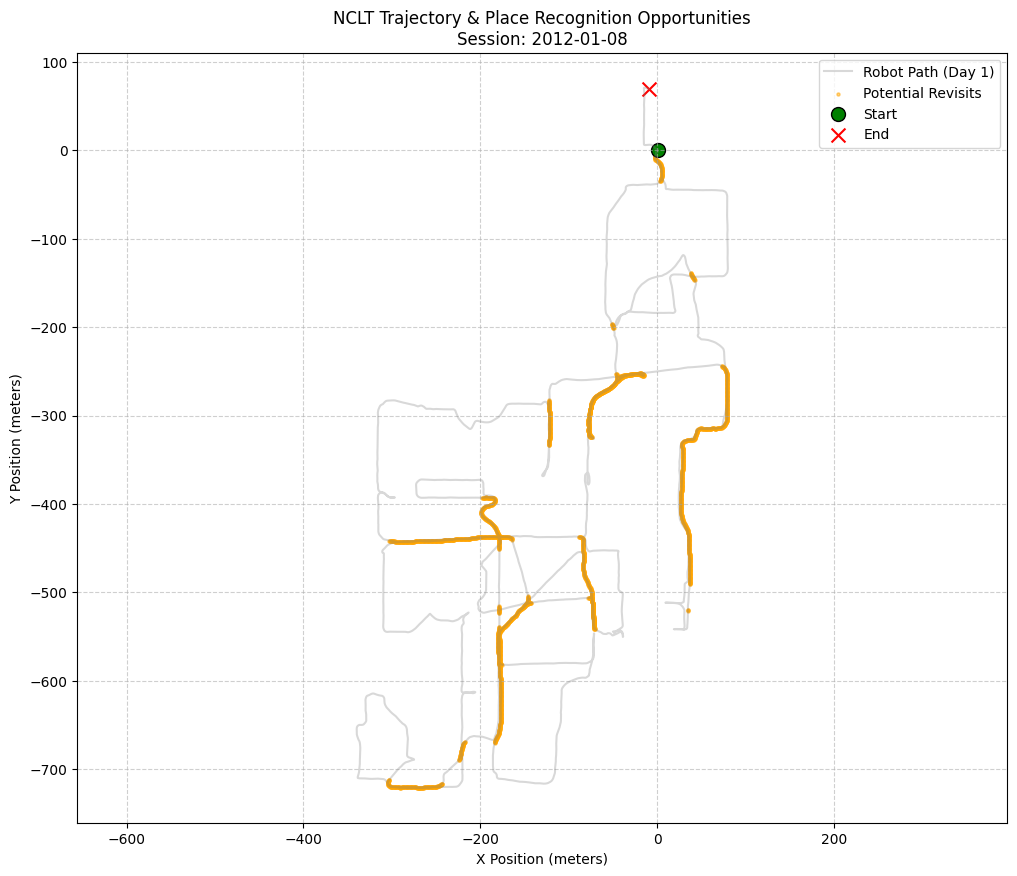

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Load and Clean Data ---
gt_file = '../data/raw/2012-01-08/groundtruth_2012-01-08.csv'
column_names = ['utime', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

# Load only once, skipping the header if it exists, or just enforcing names
df = pd.read_csv(gt_file, header=None, names=column_names)

# Convert all columns to numeric, forcing errors to NaN, then drop them
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df_clean = df.dropna(subset=['x', 'y']).copy()

print(f"Loaded {len(df_clean)} valid poses.")

# --- 2. Spatial Downsampling (Crucial for Speed) ---
# We only keep poses where the robot has moved at least 0.5 meters
downsampled_indices = [0]
last_idx = 0

x_vals = df_clean['x'].values
y_vals = df_clean['y'].values

for i in range(1, len(df_clean)):
    dist = np.sqrt((x_vals[i] - x_vals[last_idx])**2 + (y_vals[i] - y_vals[last_idx])**2)
    if dist > 0.5:
        downsampled_indices.append(i)
        last_idx = i

df_ds = df_clean.iloc[downsampled_indices].copy()
x_ds = df_ds['x'].values
y_ds = df_ds['y'].values
time_ds = df_ds['utime'].values

print(f"Downsampled to {len(df_ds)} poses for visualization.")

# --- 3. Visualization ---
plt.figure(figsize=(12, 10))

# Plot the main trajectory
plt.plot(x_ds, y_ds, color='gray', alpha=0.3, label='Robot Path (Day 1)')

# Highlight Revisits (Loop Closures)
# We find points that are spatially close (< 4m) but temporally far (> 60 seconds)
revisit_points = []
time_threshold = 60 * 1e6 # NCLT utime is in microseconds

for i in range(len(x_ds)):
    # Look ahead in time
    mask = (time_ds - time_ds[i]) > time_threshold
    if not np.any(mask): continue
    
    # Calculate distance to all future points
    dists = np.sqrt((x_ds[i] - x_ds[mask])**2 + (y_ds[i] - y_ds[mask])**2)
    
    if np.any(dists < 4.0):
        revisit_points.append([x_ds[i], y_ds[i]])

if revisit_points:
    revisit_points = np.array(revisit_points)
    plt.scatter(revisit_points[:, 0], revisit_points[:, 1], 
                color='orange', s=5, alpha=0.5, label='Potential Revisits')

# Mark Start and End
plt.scatter(x_ds[0], y_ds[0], color='green', marker='o', s=100, label='Start', edgecolors='black')
plt.scatter(x_ds[-1], y_ds[-1], color='red', marker='x', s=100, label='End')

plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('NCLT Trajectory & Place Recognition Opportunities\nSession: 2012-01-08')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') 
plt.show()

/tmp/ipykernel_17614/3660023570.py:16: DtypeWarning: Columns (0: x, 1: y, 2: z, 3: roll, 4: pitch, 5: yaw) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gt_file, header=None, names=column_names)


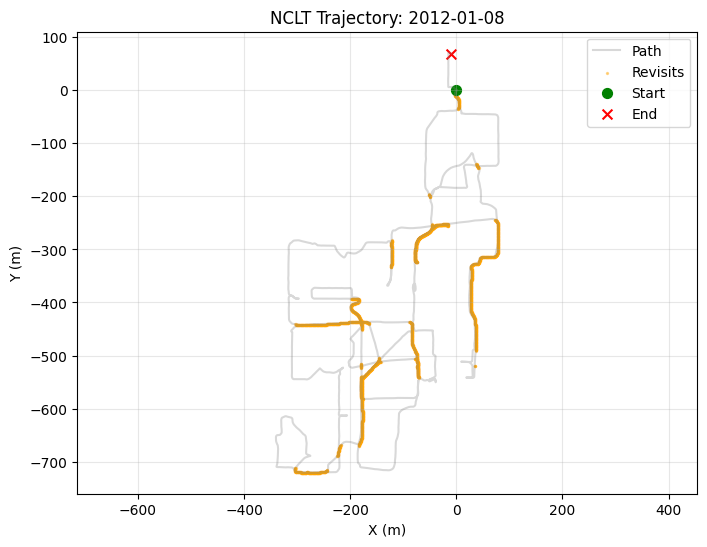

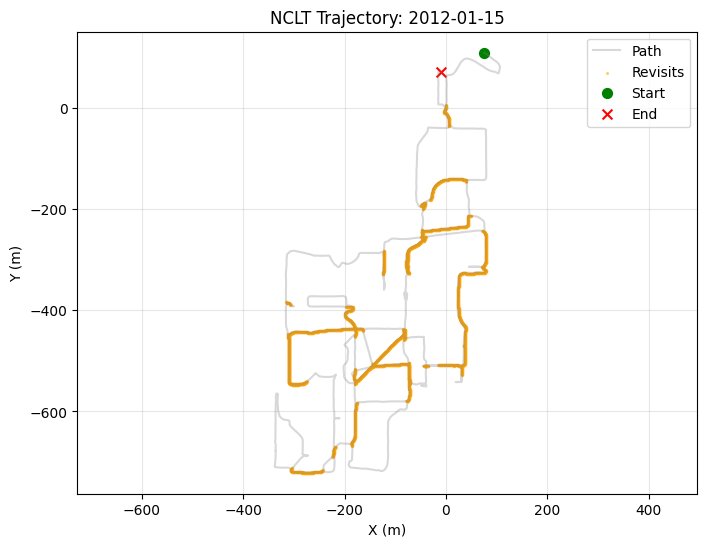

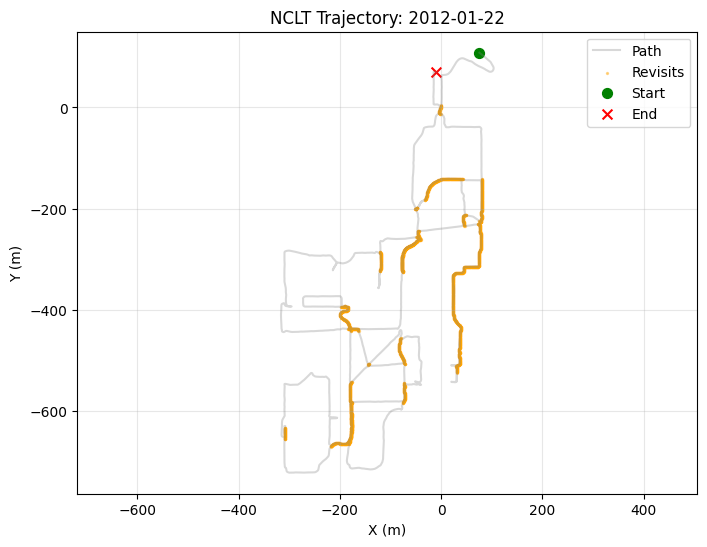

In [4]:
import os

# Define the days you have downloaded
days = ['2012-01-08', '2012-01-15', '2012-01-22']
column_names = ['utime', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

def plot_nclt_day(date_str):
    # Construct path - adjusting for your 'notebooks' directory location
    gt_file = f'../data/raw/{date_str}/groundtruth_{date_str}.csv'
    
    if not os.path.exists(gt_file):
        print(f"File not found: {gt_file}")
        return

    # Load and Clean
    df = pd.read_csv(gt_file, header=None, names=column_names)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['x', 'y'])

    # Spatial Downsampling for speed
    x_vals = df['x'].values
    y_vals = df['y'].values
    time_vals = df['utime'].values
    
    ds_idx = [0]
    last_idx = 0
    for i in range(1, len(df)):
        if np.sqrt((x_vals[i]-x_vals[last_idx])**2 + (y_vals[i]-y_vals[last_idx])**2) > 0.5:
            ds_idx.append(i)
            last_idx = i
            
    x_ds, y_ds, t_ds = x_vals[ds_idx], y_vals[ds_idx], time_vals[ds_idx]

    # Find Revisits
    revisit_x, revisit_y = [], []
    time_thresh = 60 * 1e6
    for i in range(len(x_ds)):
        future_mask = (t_ds - t_ds[i]) > time_thresh
        if not np.any(future_mask): continue
        dists = np.sqrt((x_ds[i] - x_ds[future_mask])**2 + (y_ds[i] - y_ds[future_mask])**2)
        if np.any(dists < 4.0):
            revisit_x.append(x_ds[i])
            revisit_y.append(y_ds[i])

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(x_ds, y_ds, color='gray', alpha=0.3, label='Path')
    if revisit_x:
        plt.scatter(revisit_x, revisit_y, color='orange', s=2, alpha=0.4, label='Revisits')
    plt.scatter(x_ds[0], y_ds[0], color='green', label='Start', s=50)
    plt.scatter(x_ds[-1], y_ds[-1], color='red', marker='x', label='End', s=50)
    
    plt.title(f"NCLT Trajectory: {date_str}")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.axis('equal')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run for all days
for day in days:
    plot_nclt_day(day)

/tmp/ipykernel_17614/4285321414.py:24: DtypeWarning: Columns (0: x, 1: y, 2: z, 3: roll, 4: pitch, 5: yaw) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gt_file, header=None, names=column_names)
/tmp/ipykernel_17614/4285321414.py:24: DtypeWarning: Columns (0: x, 1: y, 2: z, 3: roll, 4: pitch, 5: yaw) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gt_file, header=None, names=column_names)


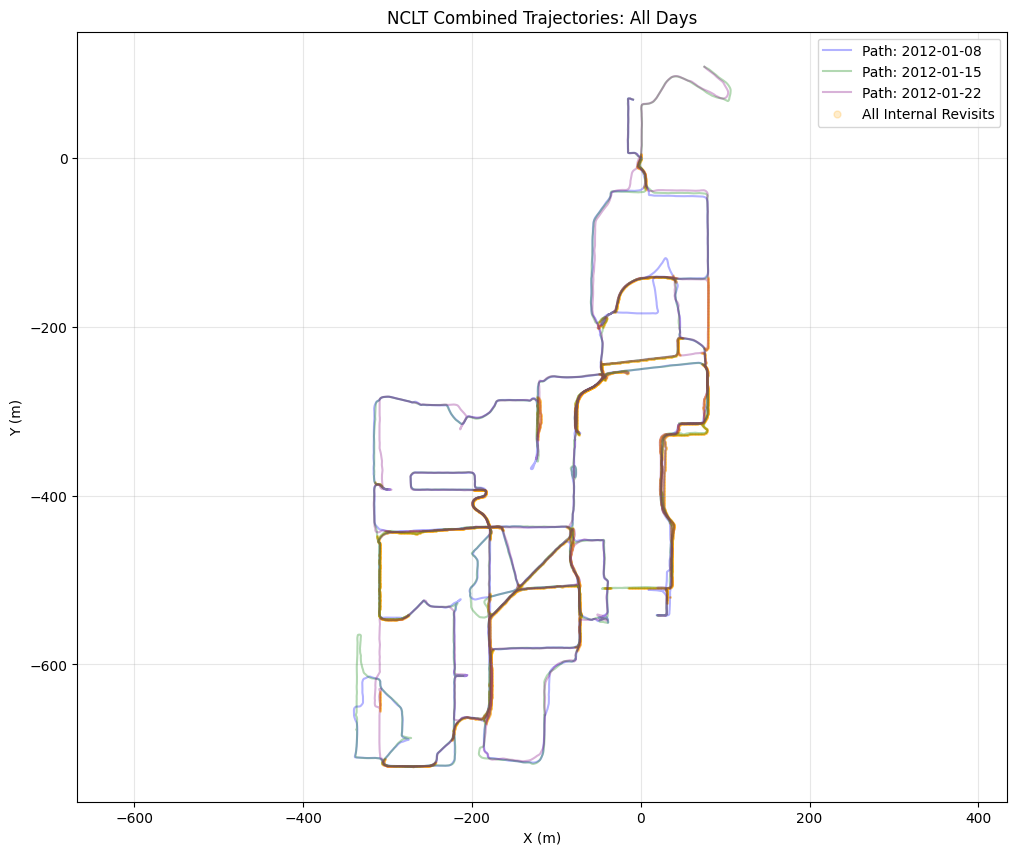

In [5]:
## lets find a find a "Golden Loop"—a specific $(x, y)$ coordinate that the robot visited on all three days

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

days = ['2012-01-08', '2012-01-15', '2012-01-22']
colors = ['blue', 'green', 'purple'] # Unique color for each day
column_names = ['utime', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

plt.figure(figsize=(12, 10))

# Lists to store "all" revisits for a final scatter layer
all_revisit_x = []
all_revisit_y = []

for i, date_str in enumerate(days):
    gt_file = f'../data/raw/{date_str}/groundtruth_{date_str}.csv'
    if not os.path.exists(gt_file):
        continue

    # 1. Load and Clean
    df = pd.read_csv(gt_file, header=None, names=column_names)
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['x', 'y'])

    # 2. Downsample
    x_vals, y_vals, t_vals = df['x'].values, df['y'].values, df['utime'].values
    ds_idx, last_idx = [0], 0
    for j in range(1, len(df)):
        if np.sqrt((x_vals[j]-x_vals[last_idx])**2 + (y_vals[j]-y_vals[last_idx])**2) > 0.5:
            ds_idx.append(j)
            last_idx = j
    
    x_ds, y_ds, t_ds = x_vals[ds_idx], y_vals[ds_idx], t_vals[ds_idx]

    # 3. Find Revisits for THIS day
    time_thresh = 60 * 1e6
    for j in range(len(x_ds)):
        future_mask = (t_ds - t_ds[j]) > time_thresh
        if not np.any(future_mask): continue
        dists = np.sqrt((x_ds[j] - x_ds[future_mask])**2 + (y_ds[j] - y_ds[future_mask])**2)
        if np.any(dists < 4.0):
            all_revisit_x.append(x_ds[j])
            all_revisit_y.append(y_ds[j])

    # 4. Plot this day's path
    plt.plot(x_ds, y_ds, color=colors[i], alpha=0.3, label=f'Path: {date_str}')

# 5. Plot all revisits found across all days in one layer
if all_revisit_x:
    plt.scatter(all_revisit_x, all_revisit_y, color='orange', s=1, alpha=0.2, label='All Internal Revisits')

plt.title("NCLT Combined Trajectories: All Days")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('equal')
plt.legend(markerscale=5) # Make legend icons visible
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
import numpy as np

def read_velodyne_bin(bin_path):
    """
    Corrected NCLT Velodyne binary reader.
    Each point is 10 bytes:
    - x (2 bytes, uint16)
    - y (2 bytes, uint16)
    - z (2 bytes, uint16)
    - intensity (1 byte, uint8)
    - laser_id (1 byte, uint8)
    - utime (2 bytes, uint16)
    """
    raw_data = np.fromfile(bin_path, dtype=np.uint16)
    
    # Each point is 10 bytes, but we read as uint16 (2 bytes each)
    # So each point is 5 uint16 elements
    num_points = len(raw_data) // 5
    raw_data = raw_data[:num_points * 5].reshape(-1, 5)
    
    # NCLT coordinates are scaled: (value * 0.005) - 100.0
    # This centers the data so 0.0 is the robot origin
    x = raw_data[:, 0].astype(np.float32) * 0.005 - 100.0
    y = raw_data[:, 1].astype(np.float32) * 0.005 - 100.0
    z = raw_data[:, 2].astype(np.float32) * 0.005 - 100.0
    
    return np.column_stack((x, y, z))

# 1. Select a middle file
import glob
sync_files = sorted(glob.glob('../data/raw/2012-01-08/2012-01-08_vel/2012-01-08/velodyne_sync/*.bin'))
test_file = sync_files[len(sync_files)//2]

# 2. Read without ANY filtering
raw_data = read_velodyne_bin(test_file)

print(f"File: {os.path.basename(test_file)}")
print(f"Number of points found: {len(raw_data)}")

if len(raw_data) > 0:
    print("\n--- Raw Sample Points (First 5) ---")
    print(raw_data[:5]) 
    
    print("\n--- Data Bounds ---")
    print(f"X range: {raw_data[:,0].min()} to {raw_data[:,0].max()}")
    print(f"Y range: {raw_data[:,1].min()} to {raw_data[:,1].max()}")
    print(f"Z range: {raw_data[:,2].min()} to {raw_data[:,2].max()}")
else:
    print("CRITICAL ERROR: The function read_velodyne_bin returned an empty array.")

File: 1326033791777689.bin
Number of points found: 41285

--- Raw Sample Points (First 5) ---
[[ 15.059998 -10.764999 -11.43    ]
 [-10.895004 -10.995003 -93.605   ]
 [-10.75     -91.045     15.589996]
 [-85.925     29.934998 -21.419998]
 [ 16.18     -11.580002  -9.340004]]

--- Data Bounds ---
X range: -99.0250015258789 to 65.46499633789062
Y range: -99.0250015258789 to 66.05499267578125
Z range: -99.0250015258789 to 59.06999206542969


Points after filtering: 3866


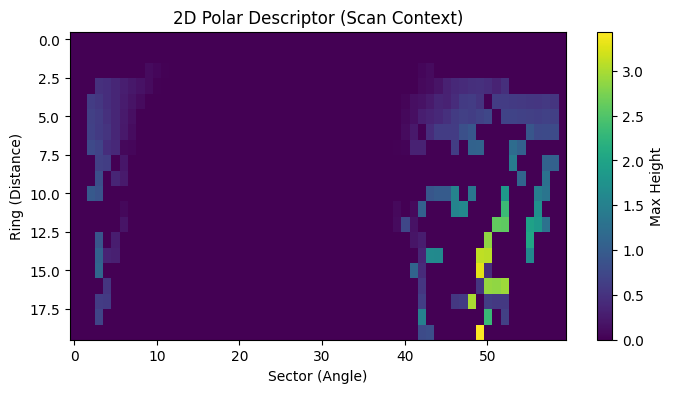

In [7]:
def generate_final_descriptor(scan, rings=20, sectors=60, max_range=40.0):
    # 1. Calculate radial distance
    r = np.sqrt(scan[:, 0]**2 + scan[:, 1]**2)
    
    # 2. Filter: 
    # Ignore points too close (robot body) or too far
    # Keep points between -0.5m and 8m height to capture stable structures (walls/trees)
    mask = (r > 2.0) & (r < max_range) & (scan[:, 2] > -0.5) & (scan[:, 2] < 8.0)
    pts = scan[mask]

    if len(pts) == 0:
        return np.zeros((rings, sectors))

    # 3. Create Polar Grid
    rho = np.sqrt(pts[:, 0]**2 + pts[:, 1]**2)
    phi = np.arctan2(pts[:, 1], pts[:, 0]) 

    descriptor = np.zeros((rings, sectors))
    
    # Map to matrix indices
    ring_idx = np.clip((rho / max_range) * rings, 0, rings - 1).astype(int)
    sector_idx = np.clip(((phi + np.pi) / (2 * np.pi)) * sectors, 0, sectors - 1).astype(int)

    # 4. Fill with Max Height for structural signature
    for i in range(len(pts)):
        if pts[i, 2] > descriptor[ring_idx[i], sector_idx[i]]:
            descriptor[ring_idx[i], sector_idx[i]] = pts[i, 2]
            
    return descriptor


# 1. Calculate distance from the sensor for every point
dist = np.sqrt(raw_data[:, 0]**2 + raw_data[:, 1]**2)

# 2. Create a mask to keep only structural data:
# Distance: > 2.0m (removes robot) and < 50.0m (removes noise/sky)
# Height (Z): > -0.8m (removes flat ground) and < 10.0m (removes tall artifacts)
mask = (dist > 2.0) & (dist < 50.0) & (raw_data[:, 2] > -0.8) & (raw_data[:, 2] < 10.0)

# 3. Apply the mask
filtered_scan = raw_data[mask]

print(f"Points after filtering: {len(filtered_scan)}")

# Test it on your loaded scan
desc = generate_final_descriptor(filtered_scan)

plt.figure(figsize=(8, 4))
plt.imshow(desc, cmap='viridis', aspect='auto')
plt.title("2D Polar Descriptor (Scan Context)")
plt.xlabel("Sector (Angle)")
plt.ylabel("Ring (Distance)")
plt.colorbar(label="Max Height")
plt.show()

In [8]:
def calculate_similarity(desc1, desc2):
    """Finds best match score by rotating columns of desc2."""
    best_score = 0.0
    num_sectors = desc1.shape[1]
    
    # Normalize descriptors for Cosine Similarity
    d1_norm = np.linalg.norm(desc1)
    
    for shift in range(num_sectors):
        # Rotate columns
        shifted_d2 = np.roll(desc2, shift, axis=1)
        d2_norm = np.linalg.norm(shifted_d2)
        
        # Calculate similarity score
        score = np.sum(desc1 * shifted_d2) / (d1_norm * d2_norm + 1e-6)
        best_score = max(best_score, score)
            
    return best_score

In [9]:
def find_best_revisit(df, dist_thresh=4.0, time_thresh_sec=120):
    x = df['x'].values
    y = df['y'].values
    t = df['utime'].values
    time_thresh = time_thresh_sec * 1e6
    
    best_dist = float('inf')
    best_pair = (None, None)
    
    # Nested loop to find the closest spatial point that is far in time
    # Using a step of 10 to speed up the search
    for i in range(0, len(df), 10):
        # Only look at points far ahead in time
        future_mask = (t - t[i]) > time_thresh
        if not np.any(future_mask): continue
        
        dists = np.sqrt((x[i] - x[future_mask])**2 + (y[i] - y[future_mask])**2)
        
        if len(dists) > 0:
            min_dist = np.min(dists)
            if min_dist < best_dist:
                best_dist = min_dist
                # Find the actual index in the original dataframe
                future_indices = np.where(future_mask)[0]
                best_pair = (i, future_indices[np.argmin(dists)])
                
    return best_pair, best_dist

# Execute the search
(idx1, idx2), final_dist = find_best_revisit(df_ds)

if idx1 is not None:
    utime1 = int(df_ds.iloc[idx1]['utime'])
    utime2 = int(df_ds.iloc[idx2]['utime'])
    print(f"Success! Found a loop closure:")
    print(f"Index 1: {idx1} (Time: {utime1})")
    print(f"Index 2: {idx2} (Time: {utime2})")
    print(f"Distance between them: {final_dist:.2f} meters")
else:
    print("Still no match. Check if your groundtruth loading (df_ds) has valid X/Y values.")

Success! Found a loop closure:
Index 1: 1020 (Time: 1326031411924939)
Index 2: 9547 (Time: 1326035171026391)
Distance between them: 0.04 meters


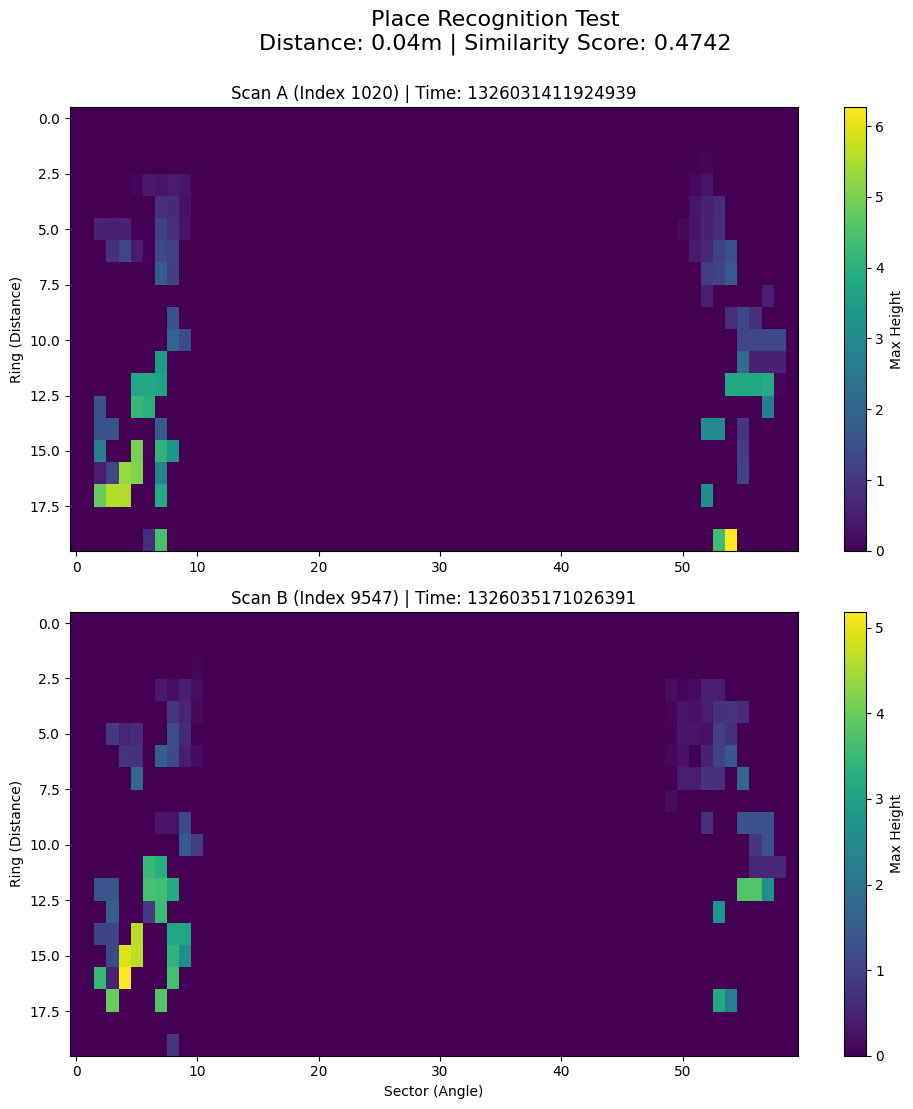

In [10]:
# 1. Use the indices found by your automated search
idx1, idx2 = 1020, 9547
utime1 = int(df_ds.iloc[idx1]['utime'])
utime2 = int(df_ds.iloc[idx2]['utime'])

# 2. Locate the corresponding .bin files
# Make sure this folder path matches your actual structure
folder = '../data/raw/2012-01-08/2012-01-08_vel/2012-01-08/velodyne_sync/'

def find_bin_by_utime(folder, target_utime):
    import glob
    files = sorted(glob.glob(os.path.join(folder, "*.bin")))
    ts = np.array([int(os.path.basename(f).split('.')[0]) for f in files])
    best_match_idx = np.argmin(np.abs(ts - target_utime))
    return files[best_match_idx]

path1 = find_bin_by_utime(folder, utime1)
path2 = find_bin_by_utime(folder, utime2)

# 3. Load and Generate Descriptors
scan1 = read_velodyne_bin(path1)
scan2 = read_velodyne_bin(path2)

# Generate descriptors (this uses the function you defined earlier)
desc1 = generate_final_descriptor(scan1)
desc2 = generate_final_descriptor(scan2)

# 4. Compare them!
score = calculate_similarity(desc1, desc2)

# 5. Visualize the result
# 1. Prepare the vertical figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12)) # Changed to 2 rows, 1 column

# 2. Plot the first descriptor (earlier visit)
im1 = ax1.imshow(desc1, cmap='viridis', aspect='auto')
ax1.set_title(f"Scan A (Index {idx1}) | Time: {utime1}")
ax1.set_ylabel("Ring (Distance)")
plt.colorbar(im1, ax=ax1, label="Max Height")

# 3. Plot the second descriptor (revisit)
im2 = ax2.imshow(desc2, cmap='viridis', aspect='auto')
ax2.set_title(f"Scan B (Index {idx2}) | Time: {utime2}")
ax2.set_xlabel("Sector (Angle)")
ax2.set_ylabel("Ring (Distance)")
plt.colorbar(im2, ax=ax2, label="Max Height")

# 4. Global title with your similarity score
plt.suptitle(f"Place Recognition Test\nDistance: {final_dist:.2f}m | Similarity Score: {score:.4f}", 
             fontsize=16, y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# Select a point far away from our original location
# idx1 was 1020; let's pick a point much further in the session
idx_neg = 5000 
utime_neg = int(df_ds.iloc[idx_neg]['utime'])
pos_neg = df_ds.iloc[idx_neg][['x', 'y']].values

# Calculate physical distance to prove they are far apart
neg_dist = np.linalg.norm(df_ds.iloc[idx1][['x', 'y']].values - pos_neg)

# Load the "Negative" scan
path_neg = find_bin_by_utime(folder, utime_neg)
scan_neg = read_velodyne_bin(path_neg)
desc_neg = generate_final_descriptor(scan_neg)

# Calculate similarity between the original Scan A and this random Scan C
neg_score = calculate_similarity(desc1, desc_neg)

print(f"Negative Match Distance: {neg_dist:.2f} meters")
print(f"Negative Similarity Score: {neg_score:.4f}")

Negative Match Distance: 195.75 meters
Negative Similarity Score: 0.3477


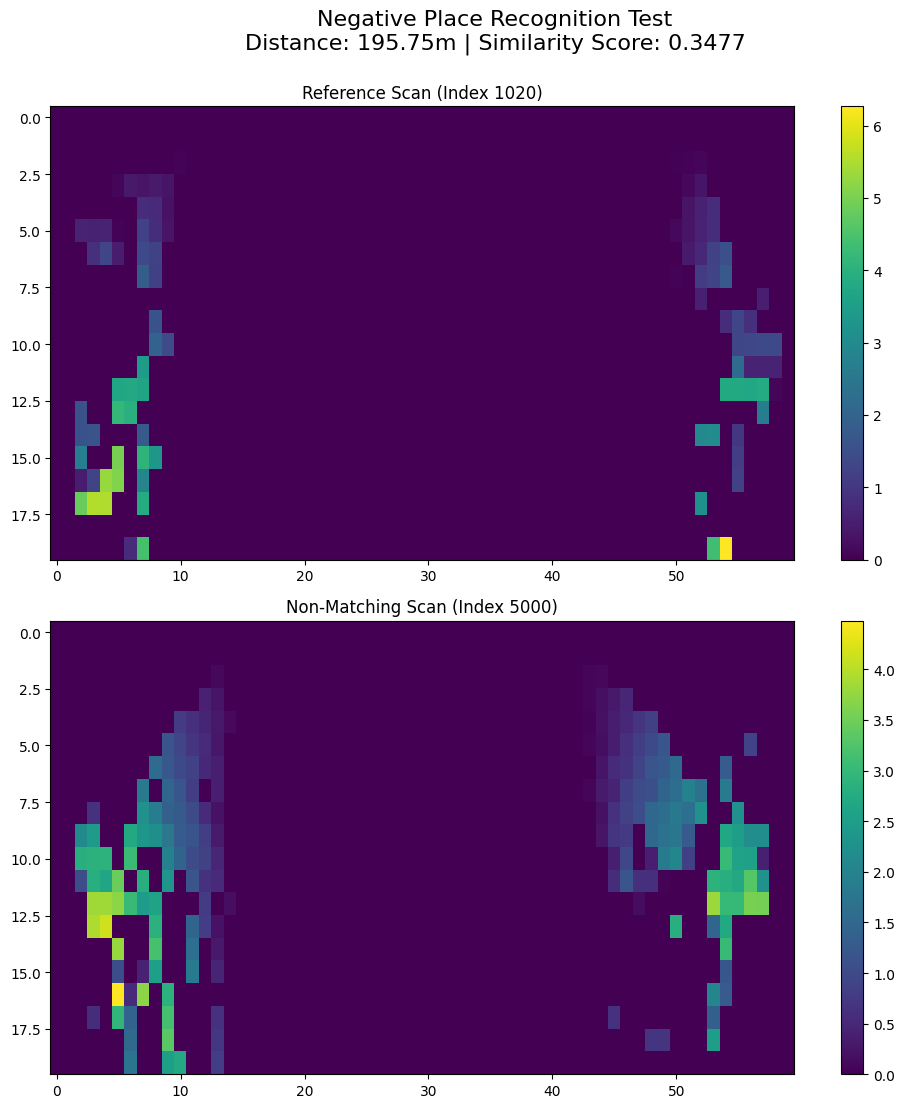

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Top: Original Scan A
im1 = ax1.imshow(desc1, cmap='viridis', aspect='auto')
ax1.set_title(f"Reference Scan (Index {idx1})")
plt.colorbar(im1, ax=ax1)

# Bottom: Negative Scan C
im2 = ax2.imshow(desc_neg, cmap='viridis', aspect='auto')
ax2.set_title(f"Non-Matching Scan (Index {idx_neg})")
plt.colorbar(im2, ax=ax2)

plt.suptitle(f"Negative Place Recognition Test\nDistance: {neg_dist:.2f}m | Similarity Score: {neg_score:.4f}", 
             fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()